# LSTM

## Read data

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Subset
import torch
from sklearn.preprocessing import MinMaxScaler
from torchtune.datasets import ConcatDataset
import optuna
import lightning.pytorch as pl
from electricity_price_forecast.data.dataset import DatasetWithWindow
from electricity_price_forecast.model.lstm_model import LSTMModel
from electricity_price_forecast.model.torch_lightning_module import TorchLightningModule
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from electricity_price_forecast.data.datamodule import Datamodule
from electricity_price_forecast.data.data_visualization import plot_prices
import logging
from electricity_price_forecast.model.lstm_model import MULTI_STEP
from electricity_price_forecast.data.data_processing import transform_synthetic_data_optimized

logging.getLogger("lightning.pytorch").setLevel(logging.WARNING)

VAL_RATIO = 0.2
TESTED_HORIZONS = [6, 12, 24, 48, 72, 168]

import error: No module named 'triton'


d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_price = pd.read_parquet("../data/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet")
df_price_generated_00257 = pd.read_parquet("../data/scenarios synthetiques/prix/00257.parquet")

print(df_price.index.min())
print(df_price.index.max())
df_price.head()

2016-12-31 23:00:00+00:00
2020-12-31 22:00:00+00:00


,price
date,
2016-12-31 23:00:00+00:00,58.82
2017-01-01 00:00:00+00:00,58.23
2017-01-01 01:00:00+00:00,51.95
2017-01-01 02:00:00+00:00,47.27
2017-01-01 03:00:00+00:00,45.49


In [3]:
print(df_price_generated_00257["dayofweek"].min())
print(df_price_generated_00257["dayofweek"].max())
df_price_generated_00257.head()

0
6


,price,dayofweek,hourofday
0,31.66,0,0
1,31.06,0,1
2,27.81,0,2
3,27.54,0,3
4,25.04,0,4


## Preprocess data

In [4]:
def preprocess_true_data(df, start_date="2016-12-31 00:00:00+00:00"):
    reference_date = pd.to_datetime(start_date)
    new_df = df.copy()
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['hourofday'] = new_df.index.hour
    new_df['dayofyear'] = new_df.index.dayofyear
    new_df['dayofseries'] = (new_df.index - reference_date).days
    new_df['dayofmonth'] = new_df.index.day  
    new_df['month'] = new_df.index.month
    new_df['year'] = new_df.index.year
    return new_df

In [5]:
df_price_preprocessed = preprocess_true_data(df_price)
df_price_preprocessed.head()

,price,dayofweek,hourofday,dayofyear,dayofseries,dayofmonth,month,year
date,,,,,,,,
2016-12-31 23:00:00+00:00,58.82,5,23,366,0,31,12,2016
2017-01-01 00:00:00+00:00,58.23,6,0,1,1,1,1,2017
2017-01-01 01:00:00+00:00,51.95,6,1,1,1,1,1,2017
2017-01-01 02:00:00+00:00,47.27,6,2,1,1,1,1,2017
2017-01-01 03:00:00+00:00,45.49,6,3,1,1,1,1,2017


In [6]:
def preprocess_synthetic_data(df, start_date="2016-12-31 00:00:00+00:00"):
    reference_date = pd.to_datetime(start_date)
    new_df = transform_synthetic_data_optimized(df, start_date)
    
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['hourofday'] = new_df.index.hour
    new_df['dayofyear'] = new_df.index.dayofyear
    new_df['dayofseries'] = (new_df.index - reference_date).days
    new_df['dayofmonth'] = new_df.index.day  
    new_df['month'] = new_df.index.month
    new_df['year'] = new_df.index.year
    
    return new_df

In [7]:
df_price_generated_00257_preprocessed = preprocess_synthetic_data(df_price_generated_00257)
df_price_generated_00257_preprocessed.head()

,price,dayofweek,hourofday,dayofyear,dayofseries,dayofmonth,month,year
date,,,,,,,,
2016-12-31 00:00:00+00:00,31.66,5,0,366,0,31,12,2016
2016-12-31 01:00:00+00:00,31.06,5,1,366,0,31,12,2016
2016-12-31 02:00:00+00:00,27.81,5,2,366,0,31,12,2016
2016-12-31 03:00:00+00:00,27.54,5,3,366,0,31,12,2016
2016-12-31 04:00:00+00:00,25.04,5,4,366,0,31,12,2016


## Plot data

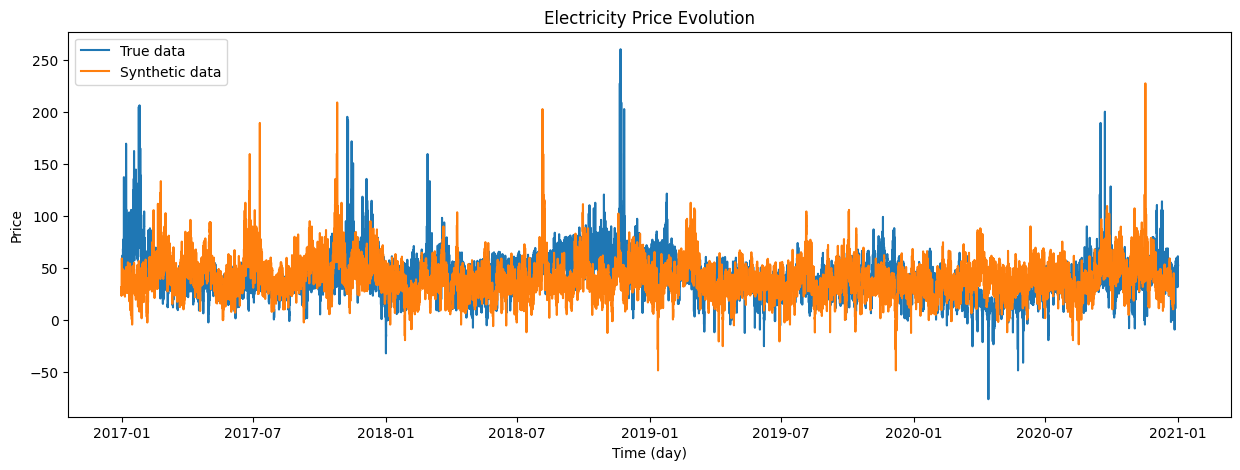

In [8]:
plot_prices([df_price_preprocessed, df_price_generated_00257_preprocessed], ["True data", "Synthetic data"])

## Training functions

In [9]:
def get_best_params(datamodule, horizon, n_trials=50):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: train_model(
        datamodule,
        horizon,
        lr=trial.suggest_float("lr", 1e-5, 1e-1),
        n_epochs=30,
        hidden_dim=trial.suggest_int("hidden_dim", 16, 512),
        n_layers=trial.suggest_int("n_layers", 1, 10),
    )[-1]["val_loss"], n_trials=n_trials)
    return study.best_params

def train_model(datamodule, horizon, early_stopping=False, lr=0.001, n_epochs=50, hidden_dim=32, n_layers=1, device="cuda"):
    train_dataloader = datamodule.train_dataloader()
    X_batch, _ = next(iter(train_dataloader))
    input_dim = X_batch.shape[-1]
    
    model_params = {
        "input_dim": input_dim,
        "hidden_dim": hidden_dim,
        "n_layers": n_layers,
        "output_dim": horizon,
        "multi_step": MULTI_STEP.ALL_AT_ONCE
    }
    
    model = TorchLightningModule(LSTMModel, model_params, lr=lr, device=device)
    
    if early_stopping:
        callbacks = [EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=False)]
    else:
        callbacks = []
        
    if device == "cuda":
        trainer = pl.Trainer(max_epochs=n_epochs, devices=-1, accelerator="cuda", callbacks=callbacks, enable_checkpointing=False, logger=False)
    else:
        trainer = pl.Trainer(max_epochs=n_epochs, callbacks=callbacks, enable_checkpointing=False, logger=False)
    
    trainer.fit(model, datamodule)
            
    return model, {"val_loss": trainer.callback_metrics["val_loss"], "train_loss": trainer.callback_metrics["train_loss"]}

def eval_model(model, dataloader, device="cuda"):
    predictions = []
    ground_truth = []
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            y_pred = model(X)
            predictions.append(y_pred)
            ground_truth.append(y)
    
    predictions = torch.cat(predictions).squeeze()
    ground_truth = torch.cat(ground_truth).squeeze()
    return TorchLightningModule.get_test_metrics(predictions, ground_truth)

def predict(model, x, device="cuda"):
    model.eval()
    model.to(device)
    y_pred = None
    
    with torch.no_grad():
        y_pred = model(x)
    
    return y_pred

def plot_predictions_vs_real(x_dates, y_true, n_before, predictions, data_normalizer=None):
    if data_normalizer:
        y_true = data_normalizer.inverse_transform_numpy(y_true.reshape(-1, 1), "price")
        predictions = data_normalizer.inverse_transform_numpy(predictions.reshape(-1, 1), "price")
    
    x_pred = x_dates[n_before-1:]
    
    # We add at beginning of predictions the last ground_truth values to have a continuous plot
    predictions = np.insert(predictions, 0, y_true[n_before-1], axis=0)
    
    plt.figure(figsize=(12,5))
    plt.plot(x_dates, y_true, color = 'r', label="True", marker='o')
    plt.plot(x_pred, predictions, color = 'b', label="Prediction", marker='x', linestyle='--')
    plt.title('Real and Predicted Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m-%d\n%H h"))

    plt.show()

## Without data augmentation

In [10]:
n_before = 10
window_size = 12
window_step = min(TESTED_HORIZONS[4], window_size)
horizon = TESTED_HORIZONS[4]
test_size = TESTED_HORIZONS[-1] + window_size # to have enough data to predict the last horizon (168 h)
dataset = DatasetWithWindow(df_price_preprocessed, window_size, window_step, horizon, ["dayofweek", "hourofday", "dayofmonth", "month", "year", "price"], "price")
# dataset = DatasetWithWindow(df_price_preprocessed, window_size, window_step, horizon, "price", "price")


# splits
def get_splits(dataset, test_size, val_ratio):
    train_split_size = len(dataset) - test_size

    val_split_size = int(train_split_size * val_ratio)
    train_split_size -= val_split_size

    test_start_idx = train_split_size + val_split_size

    train_indices = range(train_split_size)
    val_indices = range(train_split_size, test_start_idx)
    test_indices = range(test_start_idx, len(dataset))

    train_split = Subset(dataset, train_indices)
    
    if val_ratio == 0:
        val_split = None
    else:
        val_split = Subset(dataset, val_indices)
    
    if test_size == 0:
        test_split = None
    else:
        test_split = Subset(dataset, test_indices)
    
    return train_split, val_split, test_split


def get_predict_data(test_split, n_before):
    last_window_start_idx = test_split.dataset.get_last_window_idx()
    start = last_window_start_idx - n_before
    predict_dates = test_split.dataset.get_dates()[start:]
    predict_y = test_split.dataset.get_y()[start:].cpu().numpy()
    predict_x = test_split.dataset.get_X()[start:]
    
    return predict_dates, predict_y, predict_x


train_split, val_split, test_split = get_splits(dataset, test_size, VAL_RATIO)

predict_dates, predict_y, predict_x = get_predict_data(test_split, n_before=n_before)

datamodule = Datamodule(train_split, val_split, test_split, batch_size=32)

In [11]:
train_dataloader = datamodule.train_dataloader()
X_batch, y_batch = next(iter(train_dataloader))
print(len(train_dataloader))
print(X_batch.shape)
print(y_batch.shape)

69
torch.Size([32, 12, 6])
torch.Size([32, 72, 1])


#### Find best params

In [12]:
# best_params = get_best_params(datamodule, horizon, n_trials=50)

In [13]:
# best_params = {'lr': 0.00024273038278097014, 'hidden_dim': 352, 'n_layers': 2}
best_params = {'lr': 0.07425688743431168, 'hidden_dim': 274, 'n_layers': 2}
# best_params = {'lr': 0.0008968772529225413, 'hidden_dim': 155, 'n_layers': 2}
best_params

{'lr': 0.07425688743431168, 'hidden_dim': 274, 'n_layers': 2}

#### Train and eval

In [14]:
model, _ = train_model(datamodule, horizon, n_epochs=20, early_stopping=True, **best_params)

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 69/69 [00:00<00:00, 164.47it/s, train_loss=7.670, val_loss=16.40]


100%|██████████| 6/6 [00:00<00:00, 824.65it/s]

Results: {'mse': 232.48301696777344, 'mae': 10.722447395324707, 'rmse': 15.247393608093262}


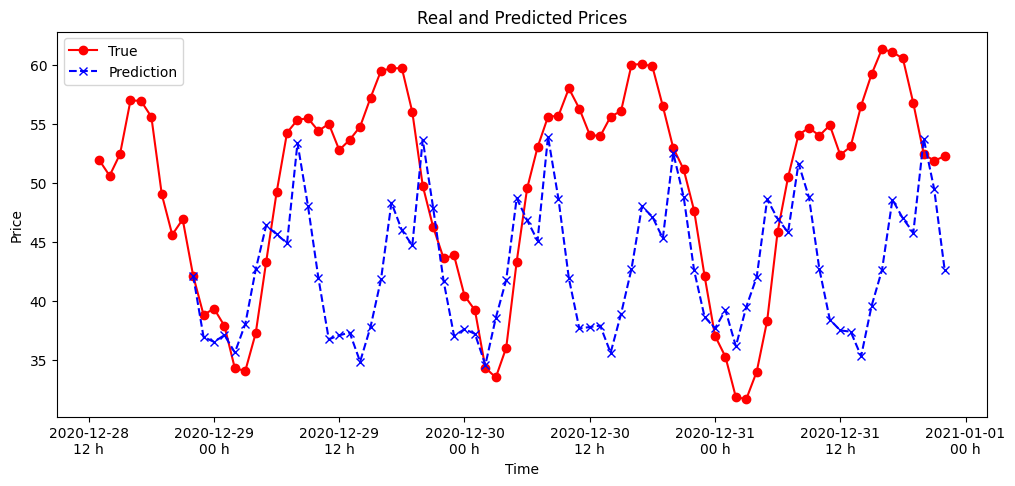

In [15]:
test_dataloader = datamodule.test_dataloader()
results = eval_model(model, test_dataloader)
print("Results:", results)

# add dim before for batch for x[:n_before] for the batch
predictions = predict(model, predict_x.unsqueeze(0), device="cuda")
# take last window ([-1, :])
predictions = predictions.cpu().numpy()[-1, :]

plot_predictions_vs_real(predict_dates, predict_y, n_before, predictions)

### With provided data augmentation (synthetic data)

In [16]:
def load_synthetic_datasets(path, window_size, window_step, horizon, max_num_fetched=None):
    if max_num_fetched is not None and max_num_fetched < 0:
        max_num_fetched = None
    train_all = []
    
    i = 0
    for filename in tqdm(os.listdir(path)):
        if max_num_fetched is not None and i >= max_num_fetched:
            break
        i += 1
        if filename.endswith(".parquet"):
            df = pd.read_parquet(path + filename)
            df_preprocessed = preprocess_synthetic_data(df)
            train_all.append(DatasetWithWindow(df_preprocessed, window_size, window_step, horizon, ["dayofweek", "hourofday", "dayofmonth", "month", "year", "price"], "price"))
    
    return train_all

In [17]:
directory = "../data/scenarios synthetiques/prix/"
train_all = load_synthetic_datasets(directory, window_size, window_step, horizon, 10)

  6%|▋         | 10/154 [00:00<00:02, 67.94it/s]


In [18]:
train_concat = ConcatDataset(train_all)

train_split_size = int(len(train_concat)*(1-VAL_RATIO))
val_split_size = len(train_concat) - train_split_size

train_split, val_split, _ = get_splits(train_concat, 0, VAL_RATIO)

predict_dates, predict_y, predict_x = get_predict_data(test_split, n_before=10)

# test_split is the same (we don't want to test on synthetic data)

datamodule = Datamodule(train_split, val_split, test_split, batch_size=32)

#### Find best params

In [19]:
# best_params = get_best_params(datamodule, horizon, n_trials=20)

In [20]:
# best_params = {'lr': 0.00024273038278097014, 'hidden_dim': 352, 'n_layers': 2}
best_params = {'lr': 0.07425688743431168, 'hidden_dim': 274, 'n_layers': 2}
# best_params = {'lr': 0.0008968772529225413, 'hidden_dim': 155, 'n_layers': 2}
best_params

{'lr': 0.07425688743431168, 'hidden_dim': 274, 'n_layers': 2}

In [21]:
model, _ = train_model(datamodule, horizon, n_epochs=20, early_stopping=True, **best_params)

d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0:   1%|          | 5/727 [00:00<00:04, 158.16it/s, train_loss=10.80]

Epoch 11: 100%|██████████| 727/727 [00:04<00:00, 151.43it/s, train_loss=11.20, val_loss=12.60]


100%|██████████| 6/6 [00:00<00:00, 749.92it/s]

Results: {'mse': 252.8312225341797, 'mae': 11.305992126464844, 'rmse': 15.900667190551758}


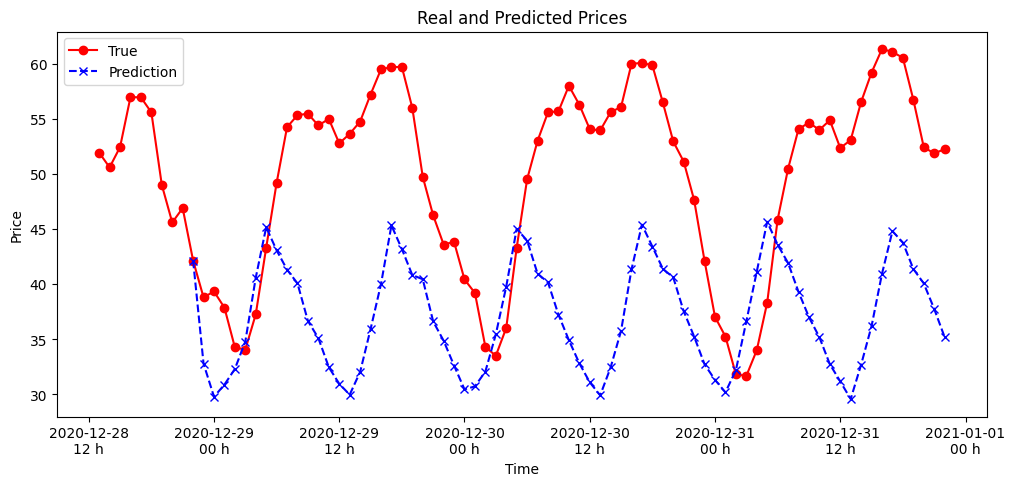

In [22]:
test_dataloader = datamodule.test_dataloader()
results = eval_model(model, test_dataloader)
print("Results:", results)

# add dim before for batch for x[:n_before] for the batch
predictions = predict(model, predict_x.unsqueeze(0), device="cuda")
# take last window ([-1, :])
predictions = predictions.cpu().numpy()[-1, :]

plot_predictions_vs_real(predict_dates, predict_y, n_before, predictions)

## With Normalization

In [23]:
class DataNormalizer():
    def __init__(self):
        self._scalers = {}
       
    def transform_df(self, df, columns=None):
        new_df = df.copy()
        if columns is None:
            columns = new_df.columns
        
        for column_name in columns:
            self._scalers[column_name] = MinMaxScaler()
            new_df[column_name] = self._scalers[column_name].fit_transform(new_df[[column_name]])
        
        return new_df
    
    def inverse_transform_numpy(self, numpy_data, column_name):
        if column_name not in self._scalers:
           raise ValueError("Unknown column name or uninitialized scaler (transform_df needs to be run before)")
        return self._scalers[column_name].inverse_transform(numpy_data)
            

In [24]:
data_normalizer = DataNormalizer()
df_price_preprocessed_normalized = data_normalizer.transform_df(df_price_preprocessed)
df_price_preprocessed_normalized.head()

,price,dayofweek,hourofday,dayofyear,dayofseries,dayofmonth,month,year
date,,,,,,,,
2016-12-31 23:00:00+00:00,0.400989,0.833333,1.000000,1.0,0.000000,1.0,1.0,0.00
2017-01-01 00:00:00+00:00,0.399232,1.000000,0.000000,0.0,0.000684,0.0,0.0,0.25
2017-01-01 01:00:00+00:00,0.380528,1.000000,0.043478,0.0,0.000684,0.0,0.0,0.25
2017-01-01 02:00:00+00:00,0.366590,1.000000,0.086957,0.0,0.000684,0.0,0.0,0.25
2017-01-01 03:00:00+00:00,0.361289,1.000000,0.130435,0.0,0.000684,0.0,0.0,0.25


In [25]:
test_size = TESTED_HORIZONS[-1] + window_size # to have enough data to predict the last horizon (168 h)
dataset = DatasetWithWindow(df_price_preprocessed_normalized, window_size, window_step, horizon, ["dayofweek", "hourofday", "dayofmonth", "month", "year", "price"], "price")
# dataset = DatasetWithWindow(df_price_preprocessed, window_size, window_step, horizon, "price", "price")

train_split, val_split, test_split = get_splits(dataset, test_size, VAL_RATIO)
predict_dates, predict_y, predict_x = get_predict_data(test_split, n_before=10)

datamodule = Datamodule(train_split, val_split, test_split, batch_size=32)

In [26]:
# best_params = get_best_params(datamodule, horizon, n_trials=50)

In [27]:
best_params = {'lr': 0.04576315047600192, 'hidden_dim': 30, 'n_layers': 8}
best_params

{'lr': 0.04576315047600192, 'hidden_dim': 30, 'n_layers': 8}

In [28]:
model, _ = train_model(datamodule, horizon, n_epochs=20, early_stopping=True, **best_params)

d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0:  78%|███████▊  | 54/69 [00:00<00:00, 152.14it/s, train_loss=0.0355]

Epoch 5: 100%|██████████| 69/69 [00:00<00:00, 139.15it/s, train_loss=0.0602, val_loss=0.0825]


100%|██████████| 6/6 [00:00<00:00, 684.60it/s]

Results: {'mse': 0.003749328898265958, 'mae': 0.050521623343229294, 'rmse': 0.061231762170791626}


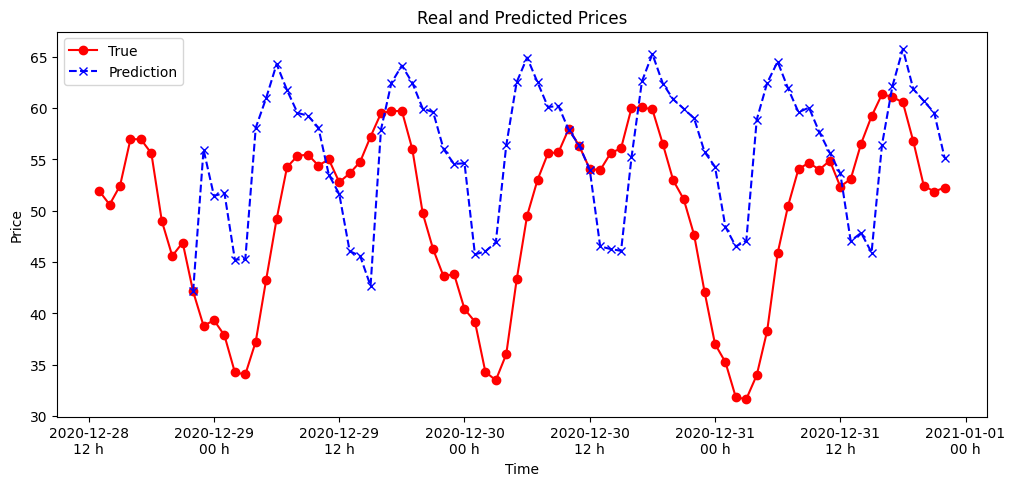

In [29]:
test_dataloader = datamodule.test_dataloader()
results = eval_model(model, test_dataloader)
print("Results:", results)

# add dim before for batch for x[:n_before] for the batch
predictions = predict(model, predict_x.unsqueeze(0), device="cuda")
# take last window ([-1, :])
predictions = predictions.cpu().numpy()[-1, :]

plot_predictions_vs_real(predict_dates, predict_y, n_before, predictions, data_normalizer)